Installing Dependencies

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

     |████████████████████████████████| 276kB 4.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=11a6e1d7e93a0b36937fefcdd79a97e57a2857005f56386e0fca6b58266d38e6
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True


Installing detectron2:

In [2]:
# install detectron2:
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After installation, you need to "restart runtime" in Colab.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 2.1MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=4641b23f806706b49ca9aea6e833e896fa5f077d2d4e932691c7e0514ff8d611
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


Importing Libraries

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import json
import cv2
import random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Reading a video

In [26]:
#Read a video and save frames to a folder:
%%time
!rm -r frames/*
!mkdir frames/

#specify path to video
video = "/content/drive/MyDrive/DLA Course Project/sample.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==525):
      break

  # Break the loop
  else: 
    break

mkdir: cannot create directory ‘frames/’: File exists
CPU times: user 26.3 s, sys: 1.11 s, total: 27.4 s
Wall time: 24.6 s


Checking the frame rate of a video:

In [27]:
#frame rate of a video
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

25.0


Downloading the pre-trained model for object detection from Detectron 2’s model zoo and then the model is ready for inference:

In [28]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

Reading an image and passing it to the model for predictions:

In [29]:
#read an image
img = cv2.imread("frames/30.png")

#pass to the model
outputs = predictor(img)

Using Visualizer to draw the predictions on the image

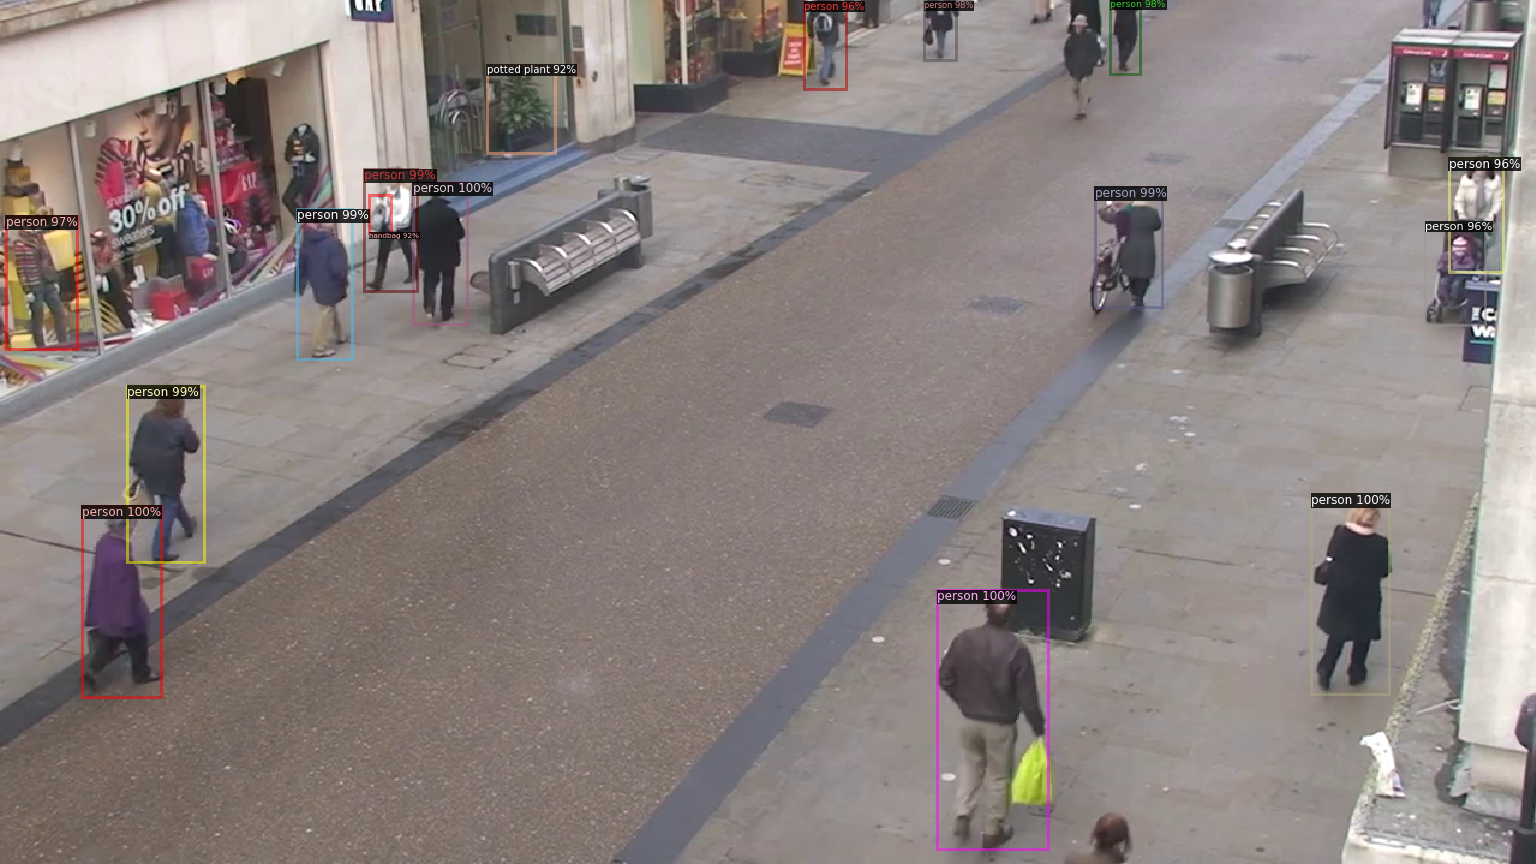

In [30]:
# Use visualizer
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

As you can see here, multiple objects are present in an image, like a person, bicycle, and so on.

In [31]:
#Understanding the objects present in an image
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 58 26]


Taking a glance at the bounding boxes of an object

In [32]:
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[7.8103461e+02 4.9196237e+02 8.7299976e+02 7.0732159e+02]
 [1.0928806e+03 4.1183420e+02 1.1577958e+03 5.7796869e+02]
 [3.4416495e+02 1.5206470e+02 3.8919257e+02 2.7020413e+02]
 [6.8453476e+01 4.2145148e+02 1.3419208e+02 5.8054663e+02]
 [1.0619268e+02 3.2134790e+02 1.6994365e+02 4.6842261e+02]
 [3.0369937e+02 1.4112000e+02 3.4769922e+02 2.4281789e+02]
 [2.4768726e+02 1.7455251e+02 2.9363245e+02 2.9941837e+02]
 [9.1241785e+02 1.5567754e+02 9.6870404e+02 2.5591391e+02]
 [7.7036139e+02 1.0755029e+00 7.9703326e+02 4.9797535e+01]
 [9.2531720e+02 7.1087033e-02 9.4964880e+02 6.1390121e+01]
 [4.6664782e+00 1.7992847e+02 6.4182808e+01 2.9098453e+02]
 [1.1878024e+03 1.8477837e+02 1.2377306e+03 2.7056555e+02]
 [1.2075078e+03 1.3146899e+02 1.2522014e+03 2.2648253e+02]
 [6.7024414e+02 1.4598303e+00 7.0483472e+02 7.3910637e+01]
 [4.0590018e+02 5.4268269e+01 4.6213470e+02 1.2756767e+02]
 [3.0785410e+02 1.6256920e+02 3.2579492e+02 1.9387386e+02]]


As different objects are present in an image, let’s identify classes and bounding boxes related to only the people:

In [33]:
#identity only persons 
ind = np.where(classes==0)[0]

#identify bounding box of only persons
person=bbox[ind]

#total no. of persons
num= len(person)

Understanding the format of the bounding box

In [34]:
x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

781.0346 491.96237 872.99976 707.3216


Drawing a bounding box for one of the people

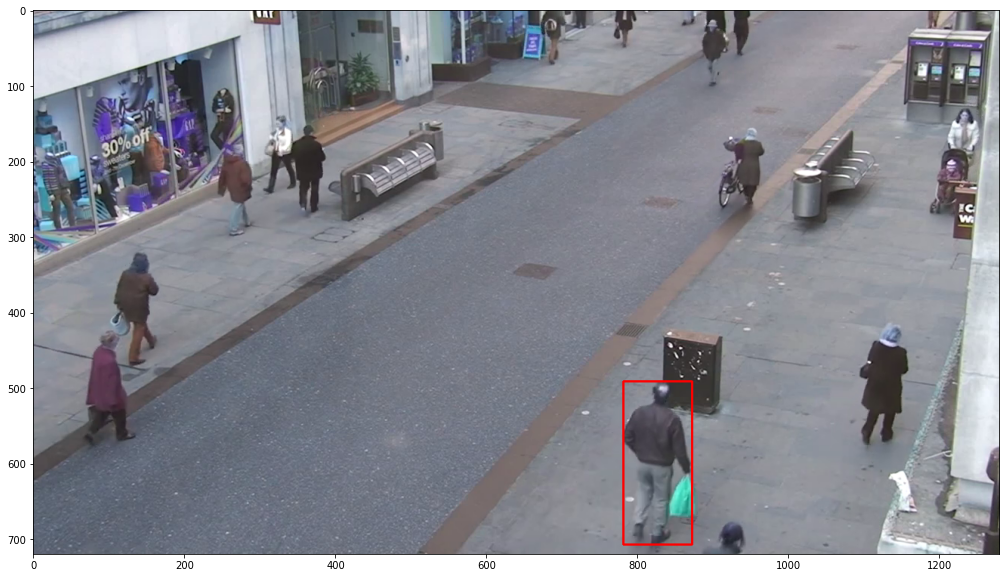

In [35]:
img = cv2.imread('frames/30.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

Our ultimate goal is to compute the distance between two people in an image. Once we know the bounding box for each person, we can easily compute the distance between any two people. But the challenge here is to select the right coordinate for representing a person as a bounding box is in the form of a rectangle.

I have chosen the bottom center of a rectangle for representing each person to measure the distance accurately and also this measure is invariant of the height of a person:

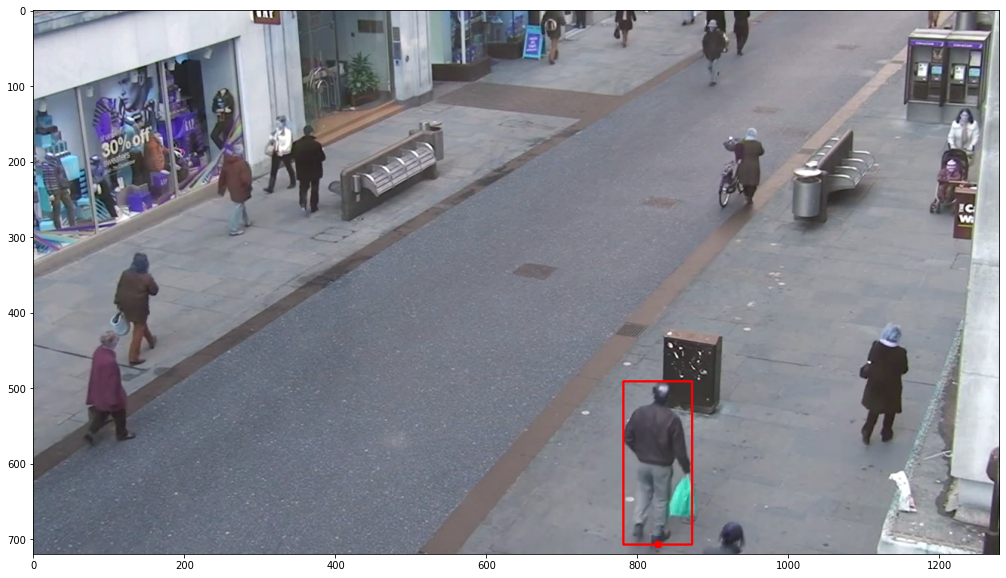

In [36]:
#compute center 
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

Defining a function that returns the bottom center of every bounding box

In [37]:

def mid_point(img,person,idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

Computing the bottom center for every bounding box and draw the points on the image

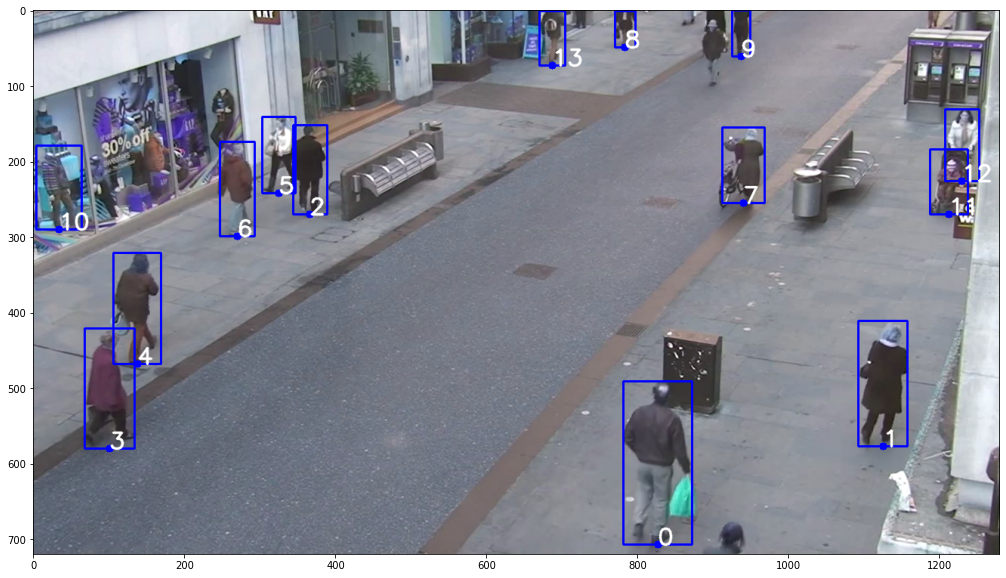

In [38]:
#call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]

#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

Defining a function to compute the Euclidean distance between every two points in an image

In [39]:
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 21.7 µs


Computing the distance between every pair of points

In [40]:
dist= compute_distance(midpoints,num)

Define a function that returns the closest people based on the given proximity distance. Proximity distance refers to the minimum distance between two people

In [41]:
%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 15.3 µs


Setting the threshold for the proximity distance. I have chosen that to be 100. Now finding the people who are within the proximity distance:

In [42]:
import pandas as pd

thresh=100
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

p1  p2       dist
0   2   5  49.648766
1   5   6  79.208585
2   8  13  98.954535
3  11  12  47.169906

From the output, we can observe that 4 people come under the red zone as the distance between them is less than the proximity threshold.

In [43]:
# define a function to change the color of the closest people to red:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)  
  return img

 Changing the color of the closest people to red:

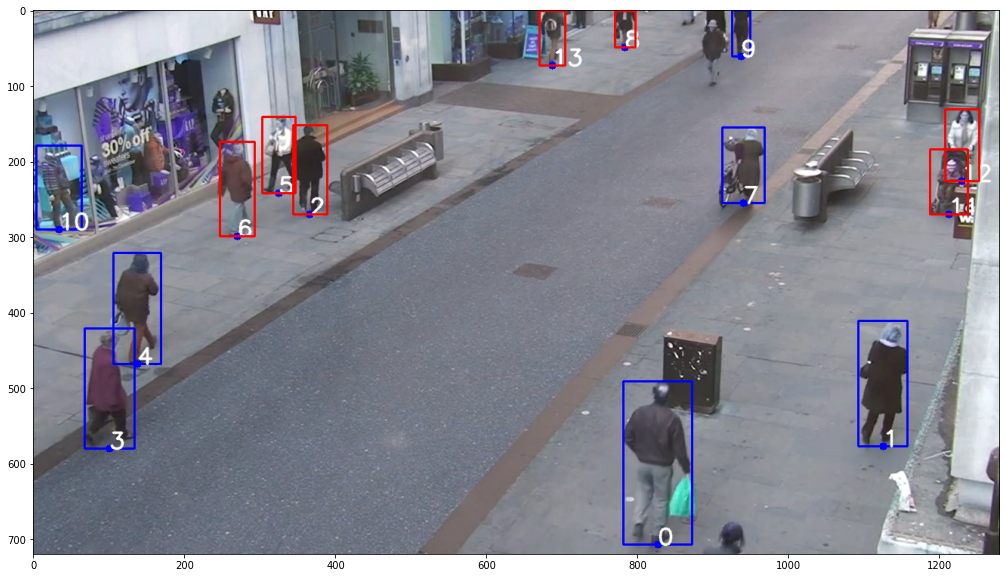

In [44]:
# change the color of the closest people to red:

img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

##Carry out similar steps on each and every frame of the video now:

In [45]:
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [46]:
# function that performs all the steps we covered on each and every frame of the video:

def find_closest_people(name,thresh):

  img = cv2.imread('frames/'+name)
  outputs = predictor(img)
  classes=outputs['instances'].pred_classes.cpu().numpy()
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person=bbox[ind]
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  num = len(midpoints)
  dist= compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)
  img = change_2_red(img,person,p1,p2)
  cv2.imwrite('frames/'+name,img)
  return 0

In [47]:
# Identify the closest people in each frame and change the color to red:

from tqdm import tqdm
thresh=100
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]


100%|██████████| 525/525 [09:01<00:00,  1.03s/it]


Convert the frames back to a video.

In [48]:
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 15.5 s, sys: 884 ms, total: 16.3 s
Wall time: 15.9 s
